In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, MaxPool2D, Conv2D, AveragePooling2D, Flatten
from keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from keras import backend as K

from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# I. Path file

In [ ]:
path_project = '/content/gdrive/MyDrive/Classroom/Computer_vision'

path_train = os.path.join(path_project, 'Data/stage/Train.npz')
path_test = os.path.join(path_project, 'Data/stage/Test.npz')

# II. Load data

In [ ]:
def load(train_path, test_path):
  Train = np.load(train_path)
  Test = np.load(test_path)
  return Train, Test

In [ ]:
Train, Test = load(path_train, path_test)
X, y = Train['X'], Train['y']
X_test = Test['X']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_val.shape

(67, 128, 128, 3)

# III. Build Model

In [ ]:
def build_model(IMG_WIDTH=128, IMG_HEIGHT=128, IMG_CHANNELS=3):
  #Build the model
  inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

  #Contraction path
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
  
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
  
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(0.2)(c6)
  c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
  
  u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(0.2)(c7)
  c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
  
  u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(0.1)(c8)
  c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
  
  u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(0.1)(c9)
  c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
model = build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
################################
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=75, callbacks=callbacks)

####################################

Epoch 1/75
34/34 [==============================] - 20s 217ms/step - loss: 0.6163 - accuracy: 0.7735 - val_loss: 0.4875 - val_accuracy: 0.7921
Epoch 2/75
34/34 [==============================] - 5s 134ms/step - loss: 0.3962 - accuracy: 0.7982 - val_loss: 0.3641 - val_accuracy: 0.7922
Epoch 3/75
34/34 [==============================] - 5s 134ms/step - loss: 0.3084 - accuracy: 0.8054 - val_loss: 0.2550 - val_accuracy: 0.8472
Epoch 4/75
34/34 [==============================] - 5s 134ms/step - loss: 0.2190 - accuracy: 0.9016 - val_loss: 0.1840 - val_accuracy: 0.9311
Epoch 5/75
34/34 [==============================] - 4s 129ms/step - loss: 0.1611 - accuracy: 0.9394 - val_loss: 0.1563 - val_accuracy: 0.9417
Epoch 6/75
34/34 [==============================] - 4s 130ms/step - loss: 0.1320 - accuracy: 0.9499 - val_loss: 0.1390 - val_accuracy: 0.9471
Epoch 7/75
34/34 [==============================] - 4s 130ms/step - loss: 0.1241 - accuracy: 0.9524 - val_loss: 0.1394 - val_accuracy: 0.9481
Epoch

# IV. Load model

In [ ]:
model = load_model("/content/gdrive/MyDrive/Classroom/Computer_vision/Data/stage/128_128/unet.h5")

In [ ]:
preds_val = model.predict(X_val, verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 61ms/step


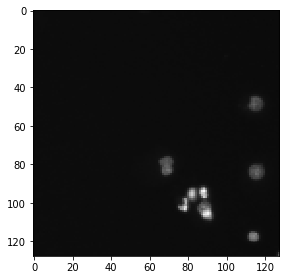

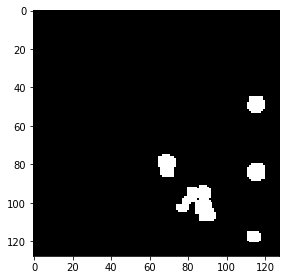

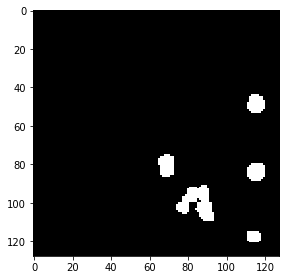

In [ ]:
ix = random.randint(0, len(preds_val_t)-1)
imshow(X_val[ix])
plt.show()
imshow(np.squeeze(y_val[ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]).astype(np.float32))
plt.show()

In [ ]:
def IoU(y_true, y_pred):
  intersection = np.logical_and(y_true, y_pred)
  union = np.logical_or(y_true, y_pred)
  iou_score = np.sum(intersection) / np.sum(union)
  return iou_score

In [ ]:
acc= []
for y_true, y_pred in zip(y_val, preds_val_t):
  score = IoU(y_true, y_pred)
  acc.append(score)
print('score: ', np.mean(acc))

score:  0.8605434953825059


##########
Demo

In [ ]:
from skimage.transform import resize
import matplotlib.pyplot as plt
path ="/content/gdrive/MyDrive/Classroom/Computer_vision/Data/stage/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png"
img = imread(path)[:,:,:3]  
img = resize(img, (128, 128), mode='constant', preserve_range=True)

In [ ]:
pred = model.predict(np.array(img.reshape(1,128,128,3)), verbose=1)
pred_t = (pred > 0.5).astype(np.uint8)

1/1 [==============================] - 1s 1s/step


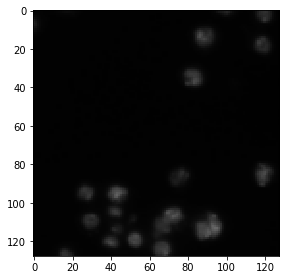

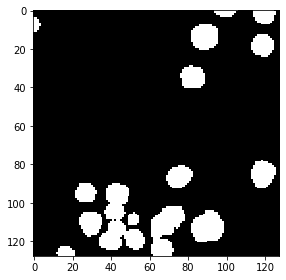

In [ ]:
imshow(img.astype(np.uint8))
plt.show()
imshow(np.squeeze(pred_t).astype(np.float32))
plt.show()